<a href="https://colab.research.google.com/github/LeonardoSanBenitez/Unlearn-Saliency/blob/master/PEM_composition_img_gen/01_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import sys
import os

is_colab: bool = 'google.colab' in sys.modules

if is_colab:
    # You need to manually create the .env file
    %cd /content
    !pip install python-dotenv
    import dotenv
    dotenv.load_dotenv()

    import os
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    # TODO: install the dependencies from our repo, not from difusers
    if not os.path.exists('diffusers'):
        !git clone https://github.com/huggingface/diffusers
    %cd diffusers
    !pip install .
    !pip install torchmetrics

    %cd examples/text_to_image
    !pip install -r requirements.txt

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default

    %cd /content/
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd /content/Unlearn-Saliency/PEM_composition_img_gen
elif "alumnos" in os.getcwd():
    # UAM computer
    %cd ~
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd ~/Unlearn-Saliency/PEM_composition_img_gen

    !python3.10 -m pip install poetry~=1.2
    !python3.10 -m poetry config virtualenvs.create true

    if os.path.exists("poetry.lock"):
        !rm poetry.lock
    !sed -i 's/python = "~3.11"/python = "~3.10"/' ./pyproject.toml
    !python3.10 -m poetry install --no-root --no-interaction --no-ansi
    
    import dotenv
    dotenv.load_dotenv()
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default
else:
    # PPKE cluster
    sys.path.append('..')  # TODO: configure this at apptainer level
    user = os.getenv('USER')
    %cd /home/{user}/Unlearn-Saliency/PEM_composition_img_gen

/home/benle1/Unlearn-Saliency/PEM_composition_img_gen


In [17]:
import datasets
from PIL import Image
import matplotlib.pyplot as plt
import random
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from typing import Literal, List, Dict, Tuple, Optional, Callable, Union

import os
import sys
import shutil

from libs.datasets import UnlearnDatasetImagenette, UnlearnDatasetCifar, UnlearnDatasetSplitMode, UnlearnDatasetSplit
from libs.utils.training import launch_accelerated_training
from libs.unlearner import UnlearnerLora, unlearn_lora
from libs.utils.logger import get_logger, setup_loggers
from libs.utils.gradient_weighting import GradientWeightingMethodMunba
from libs.metrics.image_and_text import MetricImageTextSimilarity


logger = get_logger('main')
setup_loggers(modules_info=['libs.'])

In [6]:
model_base_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"

In [7]:
free_memory, total_memory = torch.cuda.mem_get_info()  # in GB
logger.info(f"Free Memory: {free_memory / 1e9:.2f} GB")
logger.info(f"Total Memory: {total_memory / 1e9:.2f} GB")

hyperparameters = {
    "dataloader_num_workers": 2,
    "resolution": 512,
    "mixed_precision": "fp16",
    "learning_rate": 2e-4,
    "max_grad_norm": 1.0,
    "lr_scheduler": "cosine",
    "lr_warmup_steps": 0,
    "num_train_epochs": 10,
    "validation_epochs": 1,
    "checkpointing_steps": 500,
    "num_validation_images": 1,
    "seed": 42,
}

if free_memory > 20:
    hyperparameters.update({
        "train_batch_size": 16,
        "gradient_accumulation_steps": 2,
    })
elif free_memory > 14:
    hyperparameters.update({
        "train_batch_size": 4,
        "gradient_accumulation_steps": 8,
    })
else:
    logger.error('You should not even be trying...')

[2025-03-21 21:05:48 +0100] libs.main INFO     Free Memory: 41.85 GB
[2025-03-21 21:05:48 +0100] libs.main INFO     Total Memory: 42.30 GB


# Download dataset

In [25]:
#if os.path.exists('assets/imagenette_splits'):
#    shutil.rmtree('assets/imagenette_splits')
if not os.path.exists('assets/imagenette_splits'):
    for c in UnlearnDatasetImagenette.class_mapping:
        print('-'*80)
        print('Forgetting', UnlearnDatasetImagenette.class_mapping[c])
        dataset = UnlearnDatasetImagenette(
            split_mode=UnlearnDatasetSplitMode.Class,
            split_kwargs={"forget": [c]},
            download_path="assets/imagenette",
        )
        dataset.save(f"assets/imagenette_splits/{c}", format='jpg')

--------------------------------------------------------------------------------
Forgetting tench
Dataset already downloaded and extracted. Skipping download.


# Train

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training tench
[2025-03-21 21:05:52 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7659 [00:00<?, ?it/s]

[2025-03-21 21:06:01 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Num examples = 867 + 7658
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 21:06:01 +0100] libs.trainer INFO       Total optimization steps = 280


Steps:   0%|          | 0/280 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:07:55 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:09:55 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:11:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:13:50 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:15:46 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:17:42 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:19:37 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:21:33 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:23:28 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:25:23 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:25:28 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 21:25:34 +0100] libs.trainer INFO     Training completed successfully =D


/home/benle1/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang

--------------------------------------------------------------------------------
Training english_springer
[2025-03-21 21:25:34 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/861 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7666 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 21:25:44 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Num examples = 860 + 7665
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 21:25:44 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:27:44 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:29:43 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:31:40 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:33:35 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:35:31 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:37:26 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:39:21 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:41:17 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:43:11 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:45:05 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:45:09 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a english_springer.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 21:45:16 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training cassette_player
[2025-03-21 21:45:16 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/895 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7632 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 21:45:26 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Num examples = 894 + 7631
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 21:45:26 +0100] libs.trainer INFO       Total optimization steps = 280


Steps:   0%|          | 0/280 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:47:30 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:49:33 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:51:35 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:53:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:55:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:57:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 21:59:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:01:35 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:03:35 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:05:34 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:05:38 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a cassette_player.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 22:05:45 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training chain_saw
[2025-03-21 22:05:45 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/774 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7753 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 22:05:55 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Num examples = 773 + 7752
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 22:05:55 +0100] libs.trainer INFO       Total optimization steps = 250


Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:07:43 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:09:31 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:11:18 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:13:03 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:14:47 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:16:31 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:18:15 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:19:59 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:21:42 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:23:26 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:23:30 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a chain_saw.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 22:23:36 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training church
[2025-03-21 22:23:37 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/848 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7679 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 22:23:58 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Num examples = 847 + 7678
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 22:23:58 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:25:56 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:27:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:29:49 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:31:42 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:33:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:35:29 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:37:21 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:39:14 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:41:07 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:43:00 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:43:04 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a church.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 22:43:11 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training french_horn
[2025-03-21 22:43:11 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/862 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7665 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 22:43:21 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Num examples = 861 + 7664
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 22:43:21 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:45:22 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:47:21 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:49:19 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:51:16 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:53:11 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:55:07 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:57:03 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 22:58:58 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:00:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:02:48 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:02:52 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a french_horn.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 23:02:58 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training garbage_truck
[2025-03-21 23:02:58 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/866 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7661 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 23:03:08 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Num examples = 865 + 7660
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 23:03:08 +0100] libs.trainer INFO       Total optimization steps = 280


Steps:   0%|          | 0/280 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:05:09 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:07:10 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:09:09 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:11:07 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:13:05 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:15:01 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:16:58 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:18:55 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:20:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:22:50 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:22:54 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a garbage_truck.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 23:23:00 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training gas_pump
[2025-03-21 23:23:00 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/839 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7688 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 23:23:10 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Num examples = 838 + 7687
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 23:23:10 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:25:09 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:27:06 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:29:06 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:30:59 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:32:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:34:46 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:36:39 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:38:32 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:40:25 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:42:17 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:42:21 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a gas_pump.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-21 23:42:27 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training golf_ball
[2025-03-21 23:42:27 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/857 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7670 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-21 23:42:38 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Num examples = 856 + 7669
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-21 23:42:38 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:44:36 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:46:35 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:48:31 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:50:27 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:52:22 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:54:17 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:56:12 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 23:58:07 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:00:01 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:01:56 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:02:00 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a golf_ball.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-22 00:02:06 +0100] libs.trainer INFO     Training completed successfully =D


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training parachute
[2025-03-22 00:02:06 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/865 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7662 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[2025-03-22 00:02:17 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Num examples = 864 + 7661
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Num Epochs = 10
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Instantaneous batch size per device = 16
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Gradient Accumulation steps = 2
[2025-03-22 00:02:17 +0100] libs.trainer INFO       Total optimization steps = 270


Steps:   0%|          | 0/270 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:04:14 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:06:13 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:08:11 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:10:07 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:12:09 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:14:04 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:16:00 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:17:55 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:19:51 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:21:47 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-22 00:21:50 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a parachute.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[2025-03-22 00:22:07 +0100] libs.trainer INFO     Training completed successfully =D


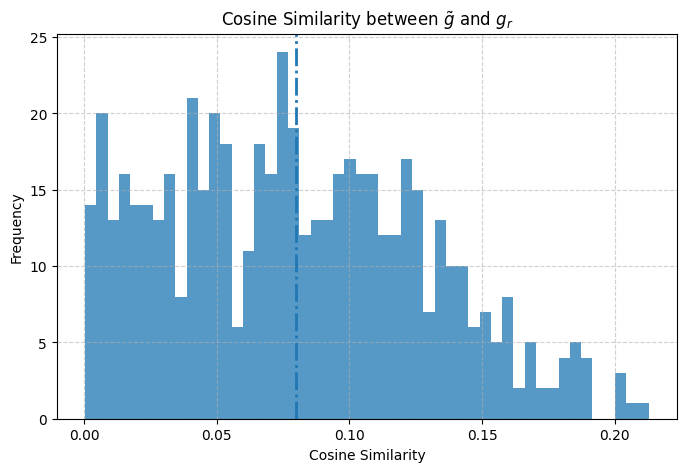

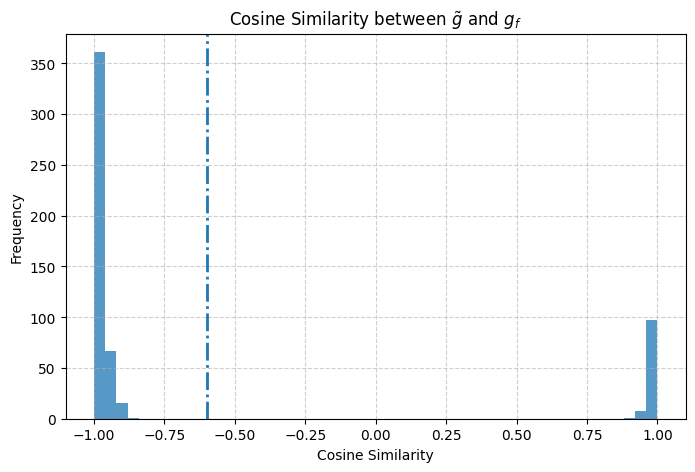

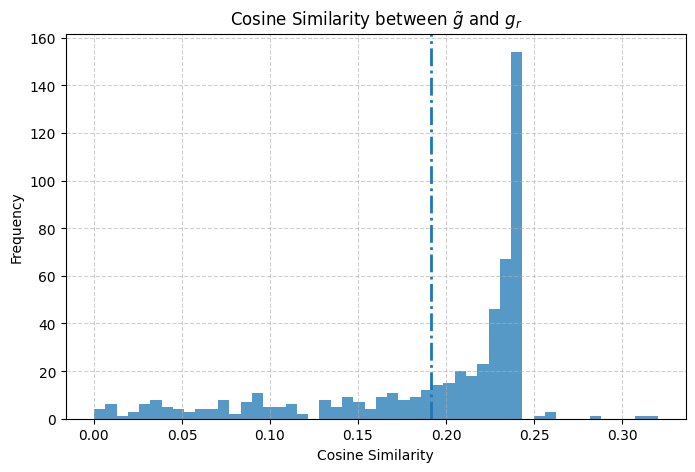

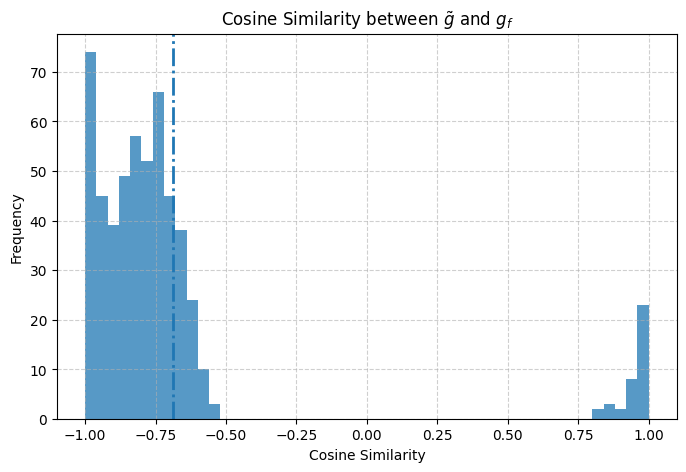

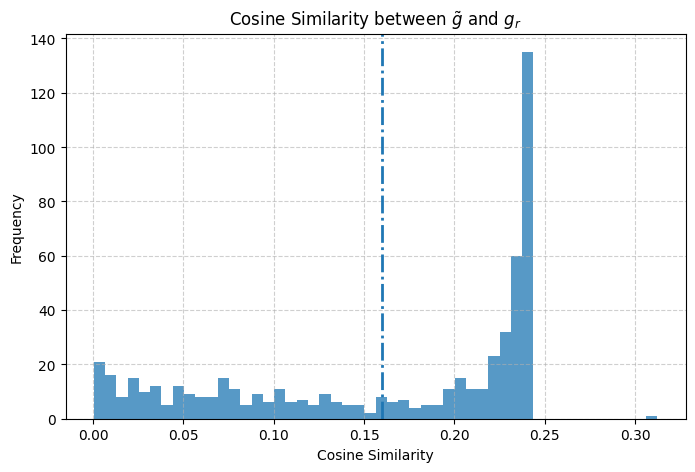

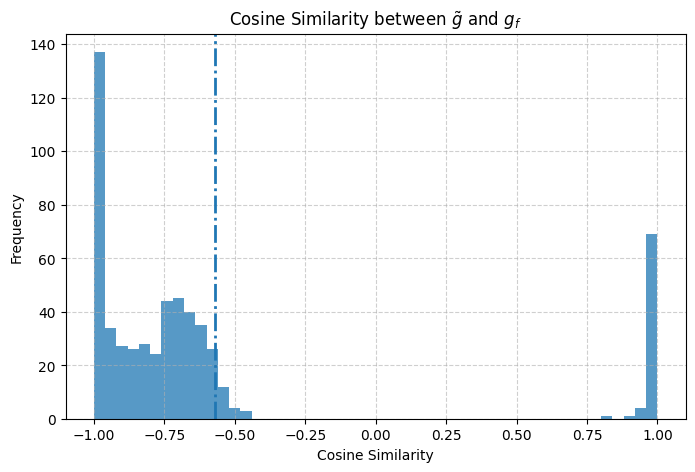

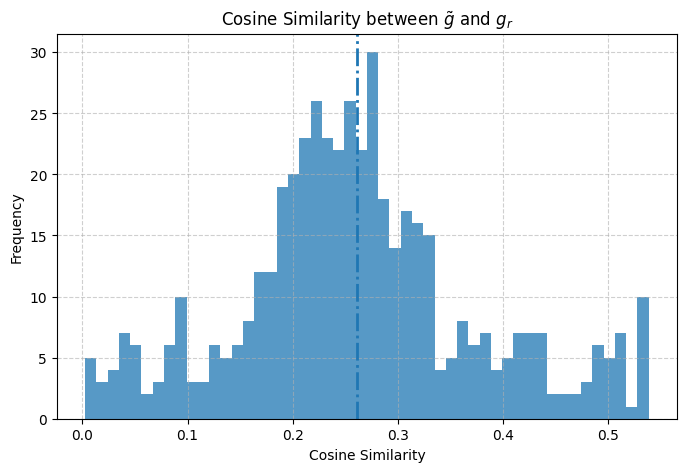

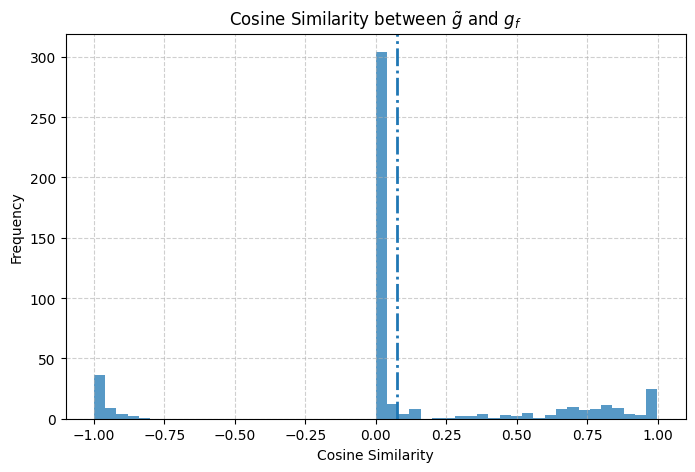

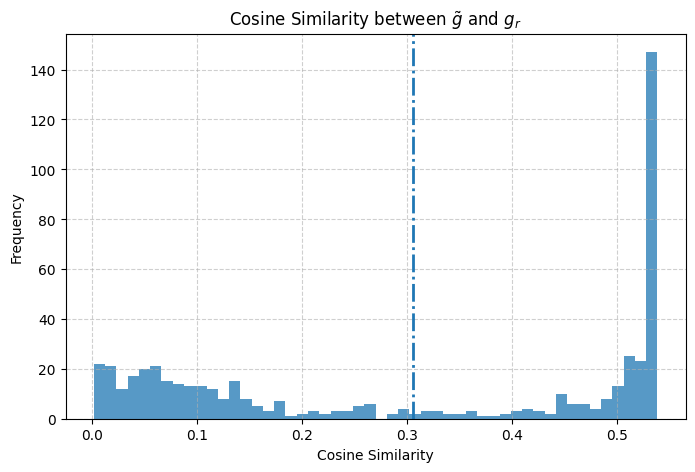

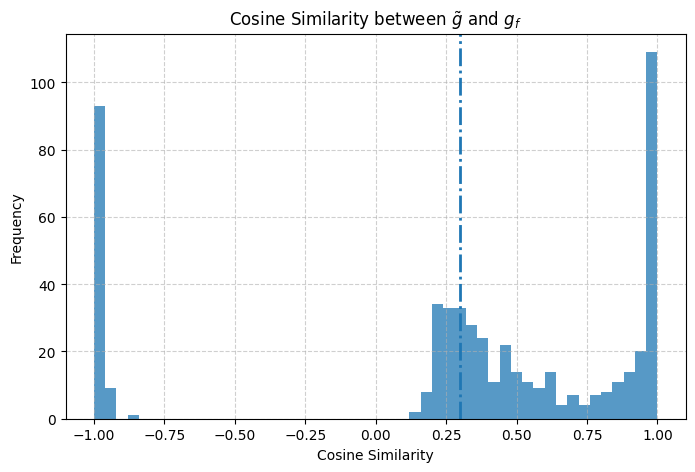

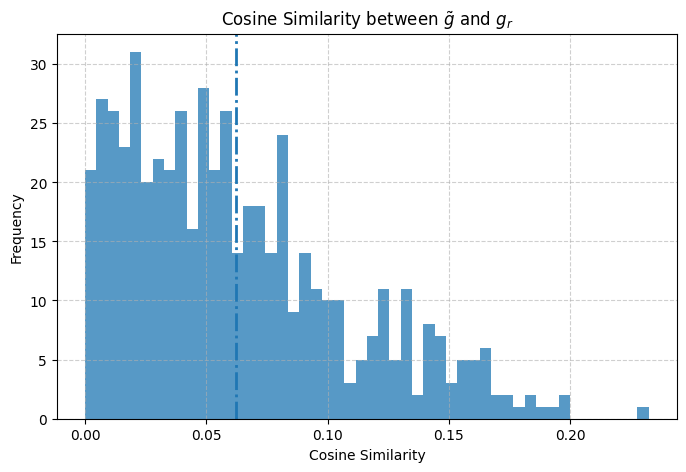

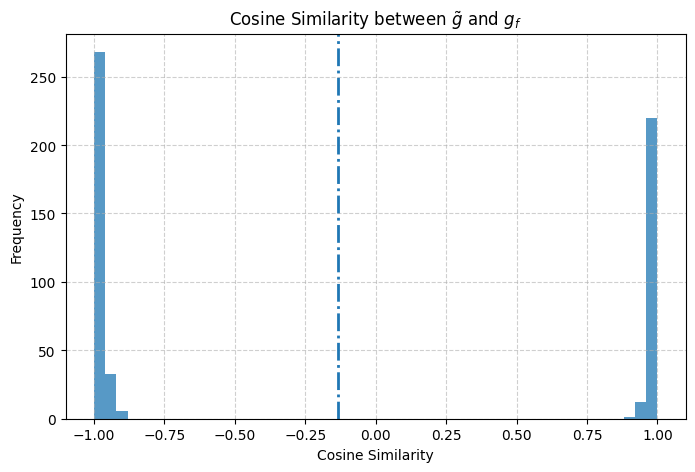

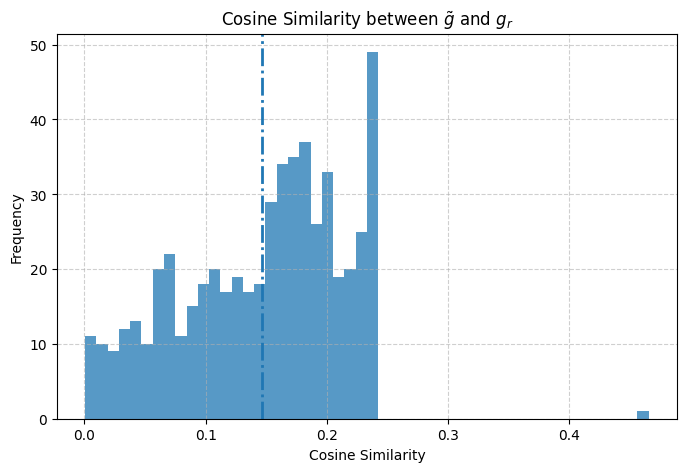

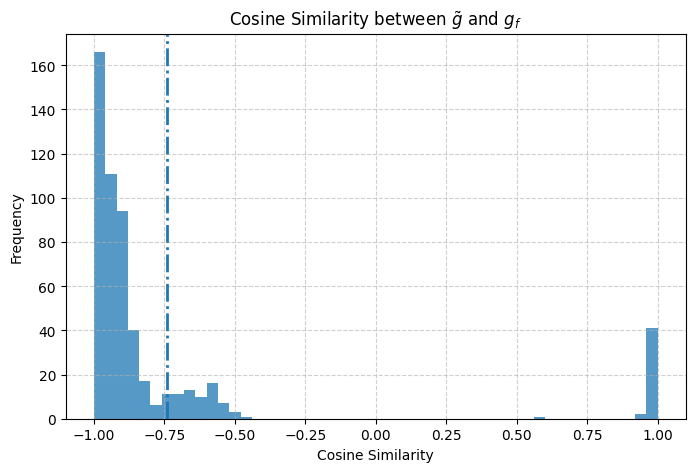

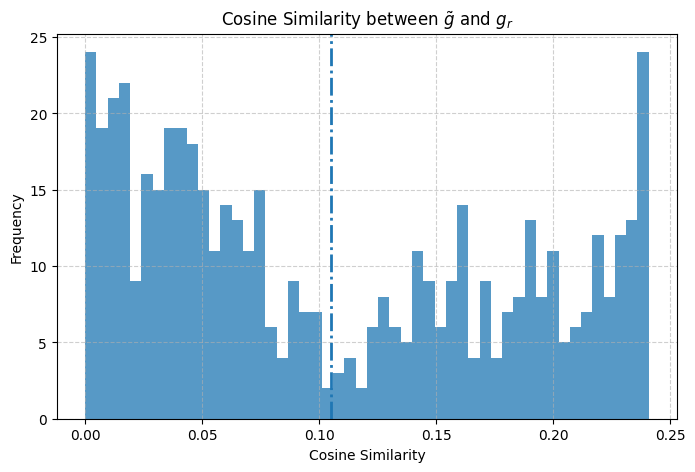

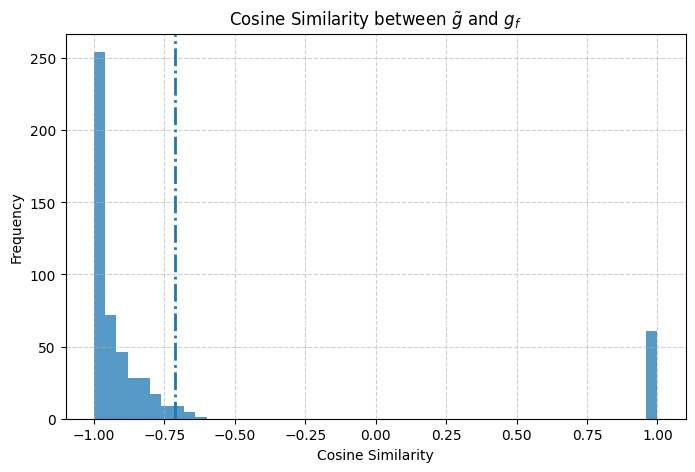

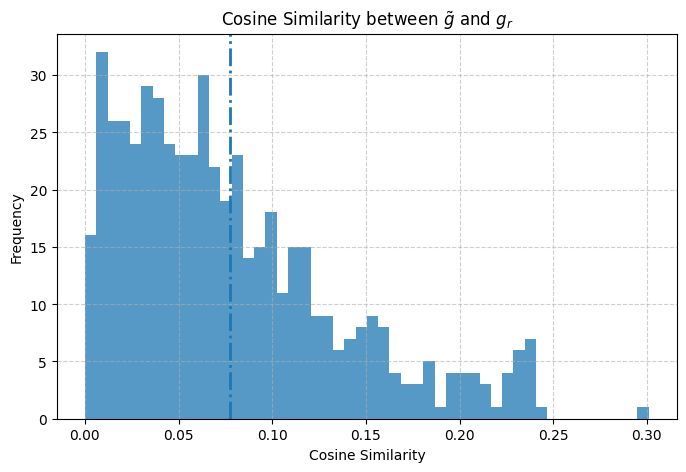

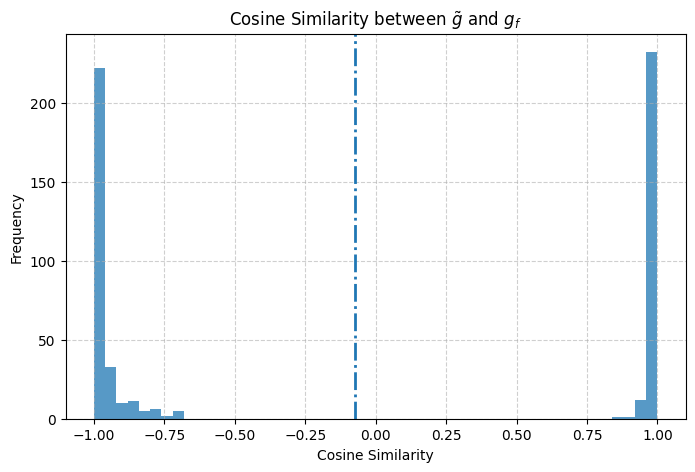

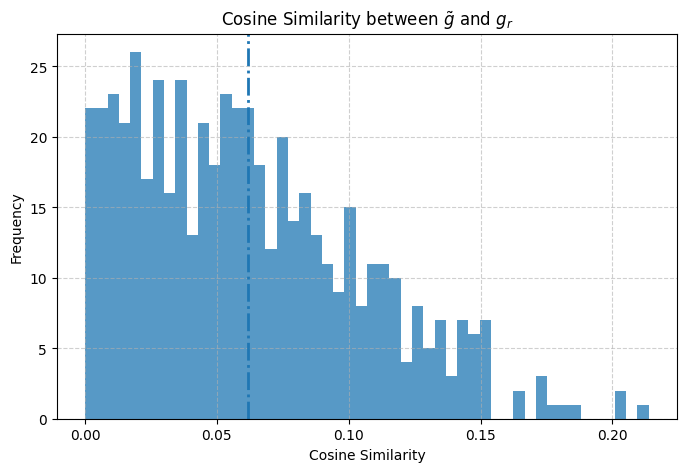

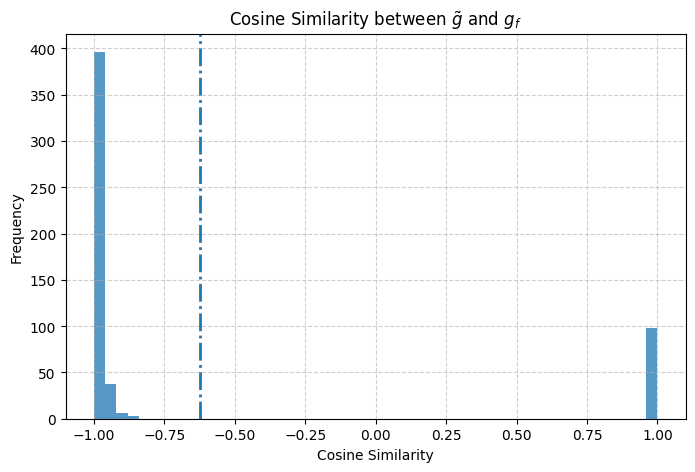

In [8]:
#if os.path.exists('assets/lora/imagenette_splits'):
#    shutil.rmtree('assets/lora/imagenette_splits')
for c in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Training', UnlearnDatasetImagenette.class_mapping[c])
    dataset_forget_name = f"./assets/imagenette_splits/{c}/train_forget"
    dataset_retain_name = f"./assets/imagenette_splits/{c}/train_retain"
    output_dir = f"./assets/lora/imagenette_splits/{c}"
    
    launch_accelerated_training(unlearner=UnlearnerLora(
        pretrained_model_name_or_path=model_base_name,
        dataset_forget_name=dataset_forget_name,
        dataset_retain_name=dataset_retain_name,
        output_dir=output_dir,
        validation_prompt=f"Picture of a {UnlearnDatasetImagenette.class_mapping[c]}",
        gradient_weighting_method = GradientWeightingMethodMunba(),
        **hyperparameters,
    ))

    #break

In [12]:
import time
run_id = int(time.time())
print(f'Backuped to {run_id}')
!cp -r ./assets/lora/imagenette_splits ./assets/lora/imagenette_splits_backup_{run_id}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Evaluation

--------------------------------------------------------------------------------
Evaluating tench


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating english_springer


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating cassette_player


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating chain_saw


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating church


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating french_horn


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating garbage_truck


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating gas_pump


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating golf_ball


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Evaluating parachute


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

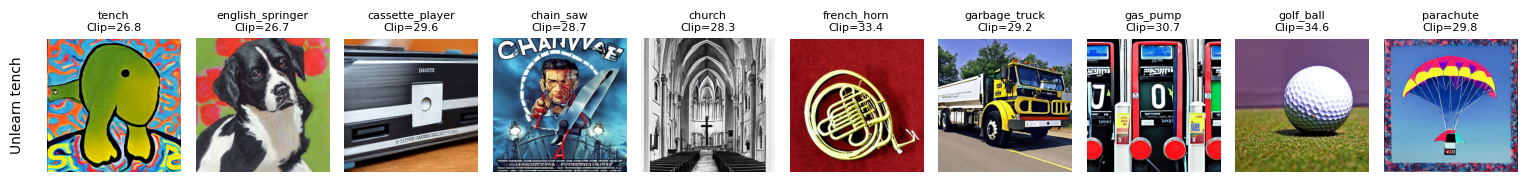

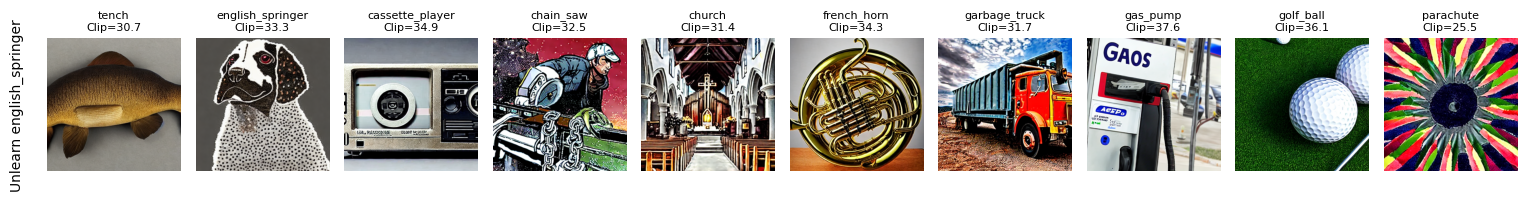

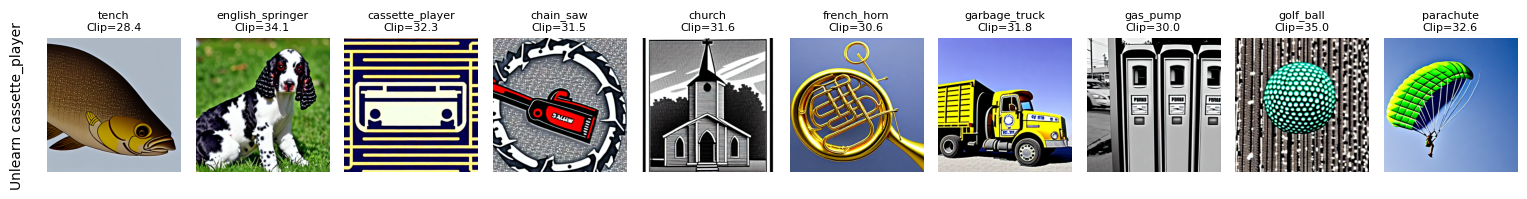

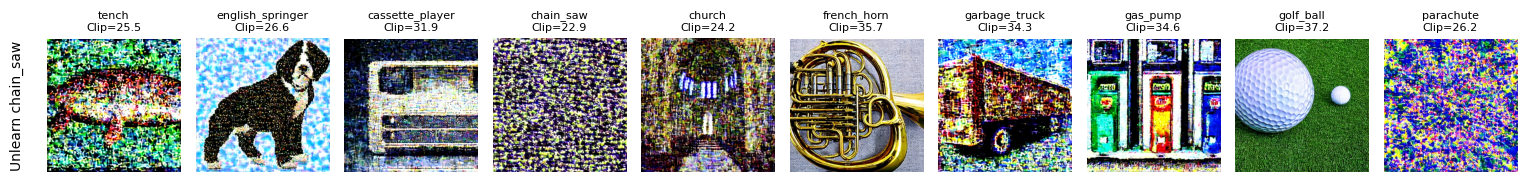

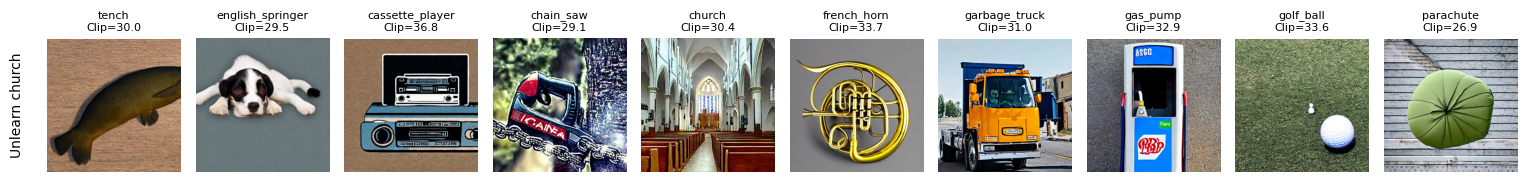

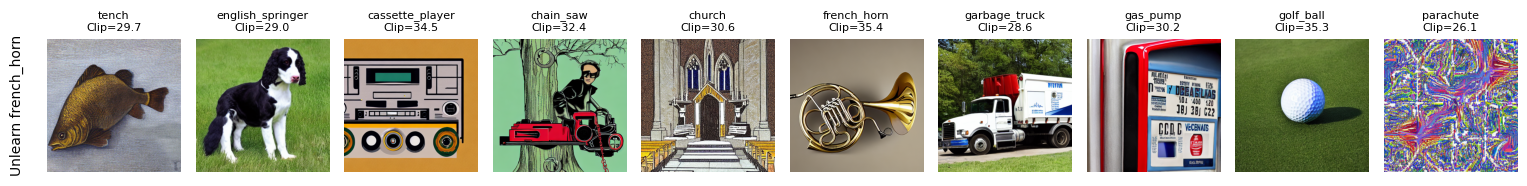

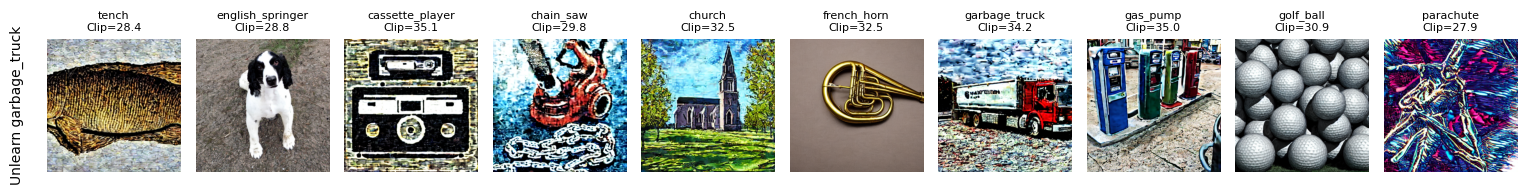

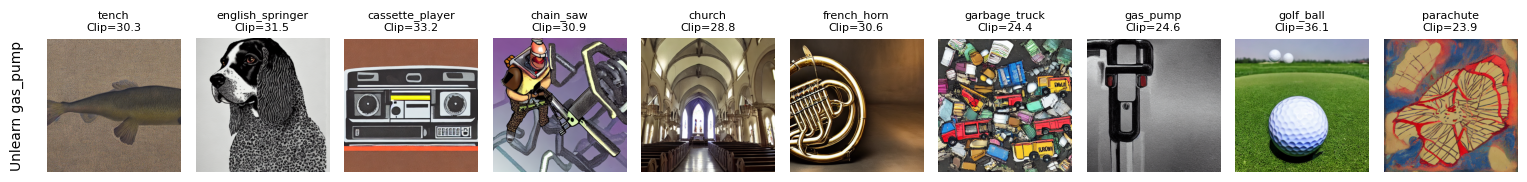

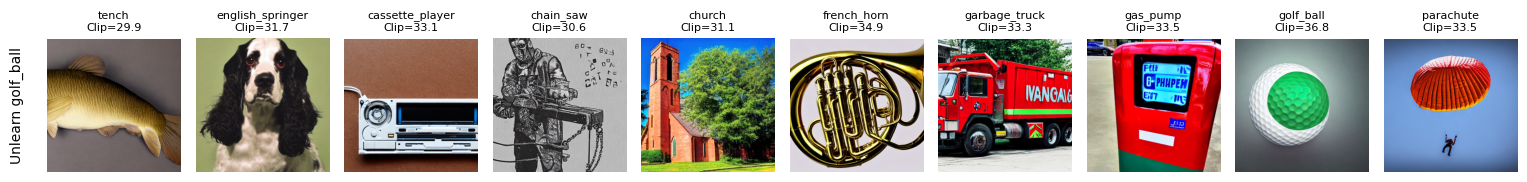

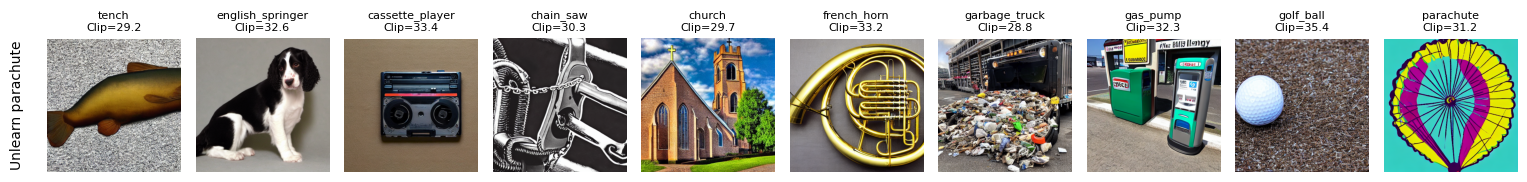

In [14]:
metric = MetricImageTextSimilarity(metrics=['clip'])
for class_model in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Evaluating', UnlearnDatasetImagenette.class_mapping[class_model])
    pipeline_original, pipeline_learned, pipeline_unlearned = unlearn_lora(
        model_original_id = "stable-diffusion-v1-5/stable-diffusion-v1-5",
        model_lora_id = f"./assets/lora/imagenette_splits/{class_model}",
        device = 'cuda',
    )
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    fig.text(-0.01, 0.5, f"Unlearn {UnlearnDatasetImagenette.class_mapping[class_model]}", rotation=90, va='center', ha='center', fontsize=10)
    for col, class_eval in enumerate(UnlearnDatasetImagenette.class_mapping):
        prompt = f"An image of {UnlearnDatasetImagenette.class_mapping[class_eval]}"
        image = pipeline_unlearned(prompt).images[0]
        score_clip: float = metric.score(image, prompt)['clip']
        axes[col].imshow(image)
        axes[col].set_title(f"{UnlearnDatasetImagenette.class_mapping[class_eval]}\nClip={score_clip:.1f}", fontsize=8)
        axes[col].axis("off")
    plt.tight_layout()
    plt.plot()
    #break